# Generative Adversarial Network on MNIST database using Keras.

## 1. Preparation 

We start our project with importing all python tools needed. We also import MNIST database with 60000 images of handwritten digits.

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

/home/agnieszka/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data() #load the data

We reshape our data, so the algorithm is easily adaptable to multichannel images, e.g. RGB. We also scale it, so the input values are contained in [0,1] interval.

In [3]:
X_train = X_train.reshape(-1,28,28,1).astype('float32')/255 # reshape, change type to float and scale
data_num = X_train.shape[0] # number of images in train set

## 2. Building components of GAN

Next step is building a function that creates discriminator. The function takes as input list of numbers of filters in *Conv2D* layers, parameter *alpha* for _LeakyReLU_ layers, type of optimizer in compilation of the model, and dropout value. We use *strides* in *Conv2D* instead of *MaxPooling*. We choose filter shape to be (5,5) in every *Conv2D* layer.

In [4]:
def create_discriminator(filters, alpha, optimizer, dropout): 
    
    discriminator = Sequential()
    
    discriminator.add(Conv2D(filters[0], 5, strides=2, input_shape=X_train.shape[1:])) 
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    
    discriminator.add(Conv2D(filters[1], 5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    
    discriminator.add(Conv2D(filters[2], 5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    
    discriminator.add(Conv2D(filters[3], 5, strides=1, padding='same'))
    discriminator.add(LeakyReLU(alpha=alpha))
    discriminator.add(Dropout(dropout))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return discriminator

Now we build function that creates generator model. The function takes as input:
* *dim* = $\frac{1}{4}$ of image side size. After two *UpSampling2D* layers we get image of shape $4*dim \times 4*dim$. 
* *depth*  - starting number of filters in convolutional layers. This is gradually reduced to 1 
* *input_dim* - size of one-dimensional noise vector
* *momentum* - parameter in BatchNotmalization layers
* *dropout* - dropout value

The function outputs a model that takes as input noise vector and outputs an image of shape $(4*dim, 4*dim,1)$

In [5]:
def create_generator(dim, depth, input_dim, momentum, dropout):
    
    generator = Sequential()
    
    generator.add(Dense(dim*dim*depth, input_dim=100))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))
    generator.add(Reshape((dim, dim, depth)))
    generator.add(Dropout(dropout))


    generator.add(UpSampling2D())
    generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))
    

    generator.add(UpSampling2D())
    generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))    

    generator.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    generator.add(BatchNormalization(momentum=momentum))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(1, 5, padding='same'))
    generator.add(Activation('sigmoid'))
    return generator

We are ready to join generator and discriminator together and build a function to create adversarial model. We will train adversarial after training disciminator, and we want to freeze parameters learned by discriminator, so that during adversarial training only parameters from generator will be updated.

In [6]:
def create_adversarial(generator, discriminator, optimizer):
    
    adversarial = Sequential()
    
    adversarial.add(generator)
    adversarial.add(discriminator)
    
    adversarial.layers[1].trainable = False
    
    adversarial.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return adversarial

## 3. Training algorithm

Let us define function which trains our GAN network. 

In [7]:
def train_GAN(epochs, batch_size, generator, adversarial):
    
    batches = int(data_num/batch_size) # number of batches
    
    d_losses = []           # create a list to store values of loss function for discriminator
    d_accuracies = []       # create a list to store values of accuracy for discriminator
    a_losses = []           # create a list to store values of loss function for adversarial
    a_accuracies =[]        # create a list to store values of accuracy for adversarial
    
    for i in range(epochs):
        
        # Create list of indices for each batch in current epoch 
        
        list_idx = list(range(data_num))                  # list of indices representing input data 
        
        np.random.shuffle(list_idx)                       # shuffle indices
        
        list_idx = list_idx[:batch_size*batches]          # take maximal amount of indices that is 
                                                          # multiple of batch size
            
        batches_idx=np.split(np.array(list_idx), batches) # split shuffled list into arrays of 
                                                          # equal size, output: list of arrays
        
        for j in range(batches):
            
            images_train = X_train[batches_idx[j]]  # take data corresponding to 
                                                    # indices for current batch
            
            # create 100 random noise vectors:
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            # generate fake images:
            images_fake = generator.predict(noise)                       
            
            # join real and fake images:
            x = np.concatenate((images_train, images_fake))              
            y = np.ones([2*batch_size, 1])
            # label fake images with 0
            y[batch_size:, :] = 0                                        
            
            # train disciminator to distinguish between real and fake images,
            # output: loss function, accuracy
            d_loss, d_acc = discriminator.train_on_batch(x, y)            
            
            # store loss function and accuracy
            d_losses.append(d_loss)
            d_accuracies.append(d_acc)
            
            # create list of labels equal 1
            y = np.ones([batch_size, 1])
            #create 100 random noise vectors
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100]) 
            
            # train adversarial on noise vectors with labels 1
            a_loss, a_acc = adversarial.train_on_batch(noise, y) 
            
            # store loss function and accuracy
            a_losses.append(a_loss)
            a_accuracies.append(a_acc)
        
    return d_losses, d_accuracies, a_losses , a_accuracies

## 4.  Training the network

Let us now define optimizers for discriminator and adversarial models.

In [8]:
optimizer_d = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
optimizer_a = Adam(lr=0.0004, clipvalue=1.0, decay=1e-10)

In [9]:
# Build discriminator, generator and adversarial models using defined functions
discriminator = create_discriminator(filters =[64,128,256,512], alpha=0.2, optimizer=optimizer_d, dropout=0.4)
generator = create_generator(dim=7, depth=256, input_dim=100, momentum=0.9, dropout=0.3)
adversarial = create_adversarial(generator, discriminator, optimizer=optimizer_a)

# Train GAN network
d_losses, d_accuracies, a_losses , a_accuracies=\
                                    train_GAN(epochs=30, batch_size=256, generator=generator, adversarial=adversarial)

/home/agnieszka/.local/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## 5. Generate images with GAN

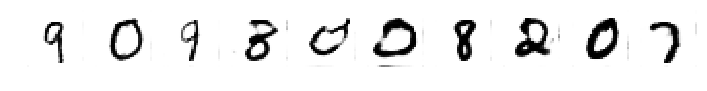

In [10]:
noise = np.random.uniform(-1.0, 1.0, size=[10, 100])
plt.figure(figsize=(12,4))
for i in range(1,11):
    plt.subplot(1, 10, i)
    plt.imshow(generator.predict(noise)[i-1][:,:,0], cmap = 'gray_r')
    plt.axis('off')
plt.show()

## 6. Loss function and accuracy

We want to see how loss function and accuracy of discriminator and adversarial changes with increasing number of epoch.


In [11]:
epochs=30

In [12]:
# Calculate mean loss for every epoch for adversarial and discriminator models
a_losses = [np.mean(arr) for arr in np.split(np.array(a_losses), epochs)]
d_losses = [np.mean(arr) for arr in np.split(np.array(d_losses), epochs)]

# Calculate mean accuracy for every epoch for adversarial and discriminator models
a_accuracies = [np.mean(arr) for arr in np.split(np.array(a_accuracies), epochs)]
d_accuracies = [np.mean(arr) for arr in np.split(np.array(d_accuracies), epochs)]

Plot loss function.

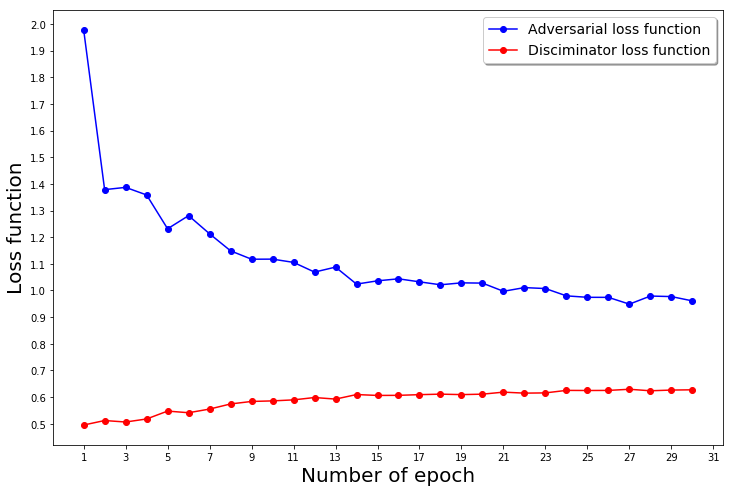

In [20]:
plt.figure(figsize=(12,8))

plt.plot(a_losses, label= 'Adversarial loss function', c='b', marker= 'o')
plt.plot(d_losses, label = 'Disciminator loss function', c='r', marker= 'o')

plt.xticks(np.arange(0,16)*2, np.arange(0,16)*2+1)
plt.yticks(np.arange(0.5,2.1,0.1))

plt.xlabel('Number of epoch', fontsize=20)
plt.ylabel('Loss function', fontsize=20)

plt.legend(shadow=True, fontsize=14)

plt.show()

Plot accuracies.

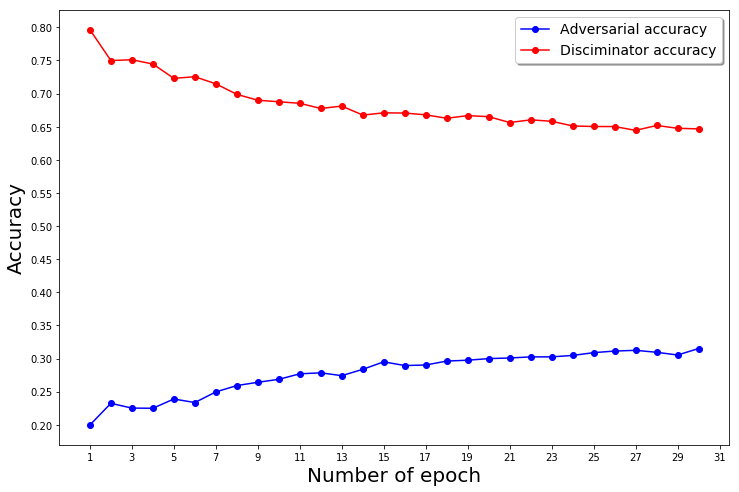

In [14]:
plt.figure(figsize=(12,8))

plt.plot(a_accuracies, label = 'Adversarial accuracy', c='b', marker= 'o')
plt.plot(d_accuracies, label = 'Disciminator accuracy', c='r', marker= 'o')

plt.xticks(np.arange(0,16)*2, np.arange(0,16)*2+1)
plt.yticks(np.arange(0.2,0.8,0.05))

plt.xlabel('Number of epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

plt.legend(shadow=True, fontsize=14)

plt.show()